Base elegida para bins logarítmicos: X = 3 (bins usados=10, vacíos=0)


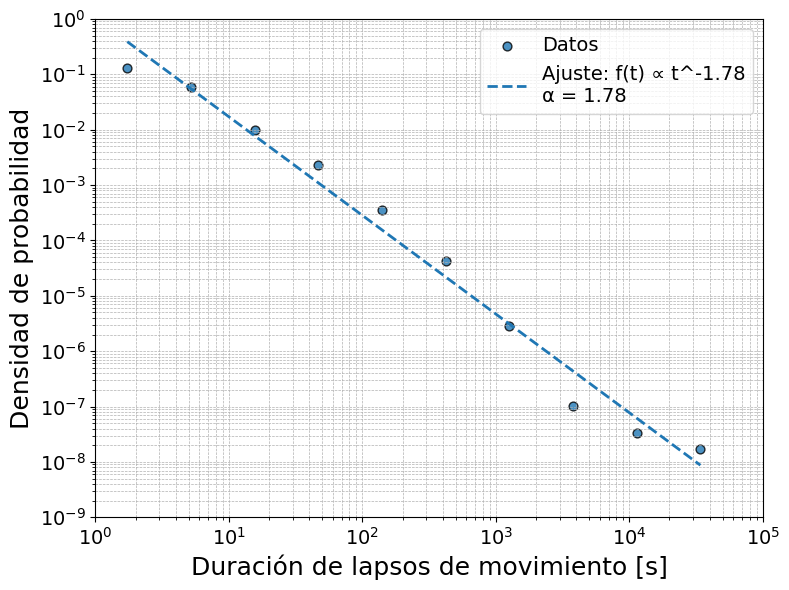

In [ ]:
from tkinter import font
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

csv_file = "pred_rf_T76.csv"        # ruta al CSV
ventana_segundos = 1.7            # duración de cada paso (s)
max_duracion = 10000000000        # valor grande para que considere todos los tamaños de lapsos de quietud o movimiento, se puede acotar
bases_posibles = [2, 3, 4, 5, 10] # bases candidatas para bins logarítmicos
min_bins_validos = 8              # asegurar al menos esta cantidad de bins no vacíos
pct_rango_ajuste = (0, 100)       # percentiles del centro de bin para el rango de ajuste
min_cuentas_bin = 1               # umbral mínimo de cuentas por bin para usar en el ajuste

df = pd.read_csv(csv_file)
preds = df["pred_rf"].to_numpy()
duraciones = []
count = 0
for val in preds:
    if val == 0:        # quieta, cambiar val == 0 por val == 1 of val == 2 para obtener la distribución de lapsos de movimiento
        count += 1
    else:               # cambio a activa -> cerrar episodio de quietud
        if count > 0:
            dur = count * ventana_segundos
            if dur <= max_duracion:
                duraciones.append(dur)
        count = 0
# si termina en quietud, cerrar el último episodio
if count > 0:
    dur = count * ventana_segundos
    if dur <= max_duracion:
        duraciones.append(dur)

duraciones = np.asarray(duraciones, dtype=float)
duraciones = duraciones[duraciones > 0]
N = len(duraciones)
if N == 0:
    raise ValueError("No se encontraron episodios de quietud > 0 s dentro del umbral.")

min_val = duraciones.min()
max_val = duraciones.max()

def construir_bins(base, vmin, vmax):
    n_min = int(np.floor(np.log(vmin)/np.log(base)))
    n_max = int(np.ceil(np.log(vmax)/np.log(base)))
    edges = base ** np.arange(n_min, n_max + 1, dtype=float)
    return edges

mejor = None
for X in bases_posibles:
    edges = construir_bins(X, min_val, max_val)
    counts, _ = np.histogram(duraciones, bins=edges)  # sin normalizar aún
    vacios = (counts == 0).sum()
    usados = (counts > 0).sum()
    # criterio: preferir pocos vacíos, y suficientes bins usados
    score = (vacios, -usados)
    if (mejor is None) or (score < mejor[0]):
        mejor = (score, X, edges, counts)

(_, _), X, edges, counts_raw = mejor
print(f"Base elegida para bins logarítmicos: X = {X} (bins usados={int((counts_raw>0).sum())}, vacíos={int((counts_raw==0).sum())})")

# Si hay muy pocos bins útiles, ampliar rango de n artificialmente
if (counts_raw > 0).sum() < min_bins_validos:
    edges = construir_bins(X, min_val*0.999, max_val*1.001)

# Densidad: f(x) = n_bin / (ancho_bin * N_total)
counts, _ = np.histogram(duraciones, bins=edges)
ancho = edges[1:] - edges[:-1]
densidad = counts / (ancho * N)
# puntos medios logarítmicos (geometric mean)
centros = np.sqrt(edges[:-1] * edges[1:])

#Selección de rango para ajustar 
mask_basico = (densidad > 0)
p_lo, p_hi = np.percentile(centros[mask_basico], pct_rango_ajuste)
mask_rango = (centros >= p_lo) & (centros <= p_hi)
mask_cuentas = (counts >= min_cuentas_bin)
mask_fit = mask_basico & mask_rango & mask_cuentas

x = np.log10(centros[mask_fit])
y = np.log10(densidad[mask_fit])

if len(x) < 3:
    print("Muy pocos bins válidos para un ajuste robusto.")
    x = np.log10(centros[mask_basico])
    y = np.log10(densidad[mask_basico])

# Ajuste lineal en log–log: y = a + b x  → pendiente b = -alpha
b, a = np.polyfit(x, y, 1)
alpha = -b

# Curva ajustada para graficar
xx = np.log10(centros)
yy_fit = a + b * xx
dens_fit = 10**yy_fit

# Graficar
plt.figure(figsize=(8,6))

plt.scatter(
    centros, densidad,
    s=40,
    edgecolor='k',
    alpha=0.8,
    label="Datos"
)

plt.plot(
    centros, dens_fit,
    '--', lw=2,
    label=f"Ajuste: f(t) ∝ t^{b:.2f}\nα = {alpha:.2f}"
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Duración de lapsos de quietud [s]", fontsize=18)
plt.ylabel("Densidad de probabilidad", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)

x_min, x_max = 1, 1e5
y_min, y_max = 1e-9, 1

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()
